## Quiz 3: KNN

1. Generate a sample using make_blobs from sklearn.datasets with n_samples = 200, center = 3, cluster_std = 1.0 and plot it using a scatter plot where different colours indicate different clusters (1 point)

2. In the KNN lecture notes, it says that there are many methods to calculate the distance between points. So far we have studied euclidean distance, so in this quiz we would like you to explore other distance measurement methods. Please implement **at least one other distance measurement method** and include it in your KNN class which you have implemented in your KNN assignment. (3 points)

Note: Your class should allow users to choose their own distance measurement method, and should raise ValueError when undefined methods was given as input

Hint: https://machinelearningmastery.com/distance-measures-for-machine-learning/

3. Perform cross validation to find the best value of k and perform classification using **all** the distance measurement methods (also raise ValueError) you have implemented. (3 points)

4. **Justify and Discuss** your results i.e. distant measurement methods, value of k, etc. (2 points)

In [1]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

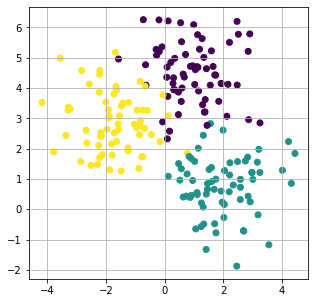

In [2]:
X, y = make_blobs(n_samples=200, centers=3,
                  random_state=0, cluster_std=1.0)

xfit = np.linspace(-1, 3.5)

figure = plt.figure(figsize=(5, 5))
ax = plt.axes()

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

In [4]:
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
class KNN:
    def __init__(self, k=3, method='euclidean'):
        self.k = k
        self.method = method

    def find_distance(self, X_train, X_test):
        if self.method == 'euclidean':
            dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
            dist = dist ** 2
            dist = dist.sum(axis=2)
            dist = np.sqrt(dist)
            return dist
        elif self.method == 'manhattan':
            dist = np.abs(X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :])
            dist = dist.sum(axis=2)
            return dist
        else:
            raise ValueError

    def find_neighbors(self, X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        neighbors_ix = np.argsort(dist)[:,:]
        return neighbors_ix
       
    def get_first_second_common(self, y, k, n_class):
        y_bincount = np.bincount(y[0:k], minlength=n_class)
        y_sort_idx = np.argsort(y_bincount)
        first_common = y_sort_idx[-1]
        second_common = y_sort_idx[-2]
        return first_common, second_common, y_bincount
    
    def find_prob(self, y_bincount):
        prob = (y_bincount / y_bincount.sum()).max()
        return prob

    def get_most_common(self, y, n_class, k):
        most_commons = []
        probs = []
        for i in range(y.shape[0]):
            first_common, second_common, y_bincount = self.get_first_second_common(y[i], k, n_class)
            
            if y_bincount[first_common] == y_bincount[second_common]:
                first_common, second_common, y_bincount = self.get_first_second_common(y[i], k+1, n_class)
                most_commons.append(first_common)
            else:
                most_commons.append(first_common)
            prob = self.find_prob(y_bincount)
            probs.append(prob)
        return np.array(most_commons), np.array(probs)

    def predict(self, X_train, X_test, y_train):
        neighbors_idx = self.find_neighbors(X_train, X_test)
        n_class = np.unique(y_train).shape[0]
        predicted, probs = self.get_most_common(y_train[neighbors_idx], n_class, self.k)
        return predicted, probs

    def cross_validate_k(self, X_train, y_train, k_range, cv):
        foldsize = int(X_train.shape[0]/cv)

        for k_value in k_range:
            self.k = k_value
            cv_score = np.zeros(cv)
            cv_prob = np.zeros(cv)

            for f_idx, f_part in enumerate(range(0, X_train.shape[0], foldsize)):
                X_test_ = X_train[f_part:f_part+foldsize]
                y_test_ = y_train[f_part:f_part+foldsize]
                X_train_ = np.concatenate((X_train[:f_part], X_train[f_part+foldsize:]))
                y_train_ = np.concatenate((y_train[:f_part], y_train[f_part+foldsize:]))
                predicts, probs = self.predict(X_train_, X_test_, y_train_)
                accuracy = np.count_nonzero(np.array([y_test_ == predicts]))/y_test_.shape[0]
                cv_score[f_idx] = accuracy
                cv_prob[f_idx] = probs.mean()

            print(f'Case k = {k_value}: score = {cv_score.mean()} average prob = {cv_prob.mean()}')

In [11]:
model = KNN(k=4, method='euclidean')
predict,_ = model.predict(X_train, X_test, y_train)
print('============== The accuracy of model ===============')
print(np.count_nonzero(np.array([y_test == predict]))/y_test.shape[0])
print('============== The classification report ===============')
print(classification_report(y_test, predict))


============== The accuracy of model ===============
0.9
============== The classification report ===============
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       1.00      0.94      0.97        18
           2       0.86      0.90      0.88        21

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [14]:
model = KNN(k=4, method='manhattan')
predict,_ = model.predict(X_train, X_test, y_train)
print('============== The accuracy of model ===============')
print(np.count_nonzero(np.array([y_test == predict]))/y_test.shape[0])
print('============== The classification report ===============')
print(classification_report(y_test, predict))

============== The accuracy of model ===============
0.9
============== The classification report ===============
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       1.00      0.94      0.97        18
           2       0.86      0.90      0.88        21

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [12]:
print('============== Cross validation for Euclidean Distance ===============')
model = KNN(method='euclidean')
k_range = np.arange(2, 20)
model.cross_validate_k(X_train, y_train, k_range, cv=10)

Case k = 2: score = 0.9642857142857142 average prob = 0.9738095238095237
Case k = 3: score = 0.9642857142857142 average prob = 0.9690476190476189
Case k = 4: score = 0.9571428571428571 average prob = 0.9592857142857143
Case k = 5: score = 0.9571428571428571 average prob = 0.9535714285714286
Case k = 6: score = 0.9571428571428571 average prob = 0.9508503401360546
Case k = 7: score = 0.9571428571428571 average prob = 0.9520408163265307
Case k = 8: score = 0.95 average prob = 0.9511904761904763
Case k = 9: score = 0.95 average prob = 0.9464285714285714
Case k = 10: score = 0.9714285714285715 average prob = 0.9438311688311689
Case k = 11: score = 0.9714285714285715 average prob = 0.9435064935064936
Case k = 12: score = 0.9571428571428571 average prob = 0.9436813186813187
Case k = 13: score = 0.9571428571428571 average prob = 0.9406593406593406
Case k = 14: score = 0.95 average prob = 0.9410544217687076
Case k = 15: score = 0.95 average prob = 0.9371428571428572
Case k = 16: score = 0.95 av

In [13]:
print('============== Cross validation for Manhattan Distance ===============')
model = KNN(method='manhattan')
k_range = np.arange(2, 20)
model.cross_validate_k(X_train, y_train, k_range, cv=10)

============== Cross validation for Manhattan Distance ===============
Case k = 2: score = 0.9571428571428571 average prob = 0.976190476190476
Case k = 3: score = 0.9571428571428571 average prob = 0.9619047619047618
Case k = 4: score = 0.9428571428571428 average prob = 0.9535714285714286
Case k = 5: score = 0.9428571428571428 average prob = 0.9514285714285714
Case k = 6: score = 0.95 average prob = 0.9527210884353743
Case k = 7: score = 0.9571428571428571 average prob = 0.9525510204081634
Case k = 8: score = 0.9642857142857142 average prob = 0.9489087301587302
Case k = 9: score = 0.9642857142857142 average prob = 0.9452380952380952
Case k = 10: score = 0.9571428571428571 average prob = 0.9427922077922076
Case k = 11: score = 0.9571428571428571 average prob = 0.940909090909091
Case k = 12: score = 0.9571428571428571 average prob = 0.9389652014652015
Case k = 13: score = 0.9571428571428571 average prob = 0.9368131868131868
Case k = 14: score = 0.9571428571428571 average prob = 0.93799319

In case of using k equal to 4. The accuracy for both distancing method Euclidean and Manhattan are the same. It has accuracy about 0.9. But if we compare with cross validation method, we can see that when k equal to 10 and using Euclidean Disctance method. It will produce highest accuracy. The value is about 0.97 for accuracy. And for Manhattan method, the best k to use is 9 with the accuracy about 0.96.